In [1]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
cfgs, btests = [], []
for p in sorted(Path("optimization").glob("*.pickle")):
    cfg, btest = pickle.load(open(p, "rb"))
    cfgs.append(cfg)
    btests.append(btest)
    # print(p)


In [3]:
opt_summary = {k:[] for k in cfgs[0].keys()}
for k in opt_summary.keys():
    for cfg in cfgs:
        v = cfg[k]
        if type(v) is EasyDict and "func" in v.keys():
            opt_summary[k].append(str(v.func.name))
        else:
            opt_summary[k].append(v)
            
opt_summary["btest"], opt_summary["ndeals"] = [], []
for btest in btests:
    opt_summary["btest"].append(btest.profits.sum())
    opt_summary["ndeals"].append(len(btest.profits))
    
opt_summary = pd.DataFrame(opt_summary)
opt_summary.sort_values(by=["btest"], ascending=False, inplace=True)
opt_summary = opt_summary[opt_summary.ticker != "NVTK"]
# opt_summary.head(10)

IndexError: list index out of range

In [ ]:
opt_res_ids = [0, 1, 2]
tickers2plot = ["BTCUSDT", "ETHUSDT"]

on_one_plot = False
plt.figure(figsize=(10, 5*(1 + (1 - on_one_plot)*len(opt_res_ids))))
plt.tight_layout()
for i, opt_res_id in enumerate(opt_res_ids):
    if not on_one_plot:
        plt.subplot(len(opt_res_ids), 1, i+1)
    legend = []
    for ticker2plot in tickers2plot:
        btest_temp = opt_summary[opt_summary.ticker == ticker2plot]
        test_id = btest_temp.index[opt_res_id]
        line = btests[test_id].profits.cumsum()
        plt.plot([pos.close_date for pos in btests[test_id].positions], line, linewidth=2)
        legend.append(f"{test_id} {cfgs[test_id].ticker}-{cfgs[test_id].period}: {cfgs[test_id].body_classifier.func.name}, sl={cfgs[test_id].stops_processor.func.name}, sl-rate={cfgs[test_id].trailing_stop_rate} -> {line[-1]:.0f}")
    plt.legend(legend)
    plt.grid("on")

In [ ]:
opt_res = {"param_set":[], "ticker":[], "btest":[], "ndeals":[], "test_ids":[]}
for i in range(opt_summary.shape[0]):
    exphash, test_ids = "", ""
    for col in opt_summary.columns:
        if col not in ["ticker", "btest", "ndeals", "no_trading_days"]:
            exphash += str(opt_summary[col].iloc[i]) + " "
    opt_res["test_ids"].append(f".{opt_summary.index[i]}")
    opt_res["param_set"].append(exphash)
    opt_res["ticker"].append(f".{opt_summary.ticker.iloc[i]}")
    opt_res["ndeals"].append(opt_summary.ndeals.iloc[i])
    opt_res["btest"].append(opt_summary.btest.iloc[i])

opt_res = pd.DataFrame(opt_res)
opt_res = opt_res.groupby(by="param_set").sum()
opt_res.sort_values(by=["btest"], ascending=False, inplace=True)
# opt_res.head(20)

In [ ]:
plt.figure(figsize=(15, 10))
opt_res_id = 0
legend = []
for test_id in map(int, opt_res.test_ids.iloc[opt_res_id].split(".")[1:]):
    line = btests[test_id].profits.cumsum()
    plt.plot([pos.close_date for pos in btests[test_id].positions], 
             line, 
             linewidth=2)
    legend.append(f"{test_id} {cfgs[test_id].ticker}-{cfgs[test_id].period}: {cfgs[test_id].body_classifier.func.name}, sl={cfgs[test_id].stops_processor.func.name}, sl-rate={cfgs[test_id].trailing_stop_rate} -> {line[-1]:.0f}")
plt.legend(legend)
plt.grid("on")

In [ ]:
import numpy as np
import pandas as pd


def calc_metrics(ts):
    ymax = ts[0]
    twait = 0
    twaits = []
    h = []
    for y in ts:
        if y >= ymax:
            ymax = y
            if twait>0:
                #print(t, twait ,ymax)
                twaits.append(twait)
                twait = 0
        else:
            twait += 1
        h.append(ymax)
    max_loss = (np.array(h) - ts).max()
    twaits = np.array(twaits) if len(twaits) else np.array([len(ts)])
    return np.median(twaits), twaits.max(), max_loss, h

def convert_hist(t0, t1, btest):
    dates2load = pd.date_range(start="/".join([t0.split(".")[i] for i in [1, 2, 0]]), 
                            end="/".join([t1.split(".")[i] for i in [1, 2, 0]]), 
                            freq="D")
    source_dates = [pd.to_datetime(pos.close_date).date() for pos in btest.positions]
    target_dates = [pd.to_datetime(d).date() for d in dates2load]
    profit = btest.profits.cumsum()
    balance = [0]
    unbias=False
    for d in target_dates:
        # Select balance records with same day
        day_profs = [balance[-1]] + [b for b, sd in zip(profit, source_dates) if sd == d]
        # If there are records for currend day, store latest of them, else fill days with no records with latest sored record
        balance.append(day_profs[-1])
    res = np.array(balance)
    if unbias:
        res = res - profit[0]
    return res

In [ ]:
t0 = "2017.01.01"
t1 = "2024.01.01"
ids = list(map(int, opt_res.test_ids.iloc[opt_res_id].split(".")[1:]))
ids = [10, 31]
test1 = convert_hist(t0, t1, btests[ids[0]])
test2 = convert_hist(t0, t1, btests[ids[1]])
test_av = (test1+test2)/2
tw_mean, tw_max, loss_max, prof_max = calc_metrics(test_av)

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(test1)
plt.plot(test2)
plt.plot(test2)
plt.plot(test_av)
plt.plot(prof_max, alpha=0.4)
print(test_av[-1], tw_mean, tw_max, loss_max/test_av[-1]*100)

In [4]:
cfgs, btests = [], []
for p in sorted(Path("optimization/data_M15/").glob("*.pickle")):
    cfg, btest = pickle.load(open(p, "rb"))
    cfgs.append(cfg)
    btests.append(btest)
    print(p)


optimization/data_M15/btest.00.01.ETHUSDT.pickle
optimization/data_M15/btest.01.01.BTCUSDT.pickle
optimization/data_M15/btest.02.01.ETHUSDT.pickle
optimization/data_M15/btest.03.01.BTCUSDT.pickle
optimization/data_M15/btest.04.01.ETHUSDT.pickle
optimization/data_M15/btest.05.01.BTCUSDT.pickle
optimization/data_M15/btest.06.01.ETHUSDT.pickle
optimization/data_M15/btest.07.01.BTCUSDT.pickle
optimization/data_M15/btest.08.01.ETHUSDT.pickle
optimization/data_M15/btest.09.01.BTCUSDT.pickle
optimization/data_M15/btest.10.01.ETHUSDT.pickle
optimization/data_M15/btest.11.01.BTCUSDT.pickle
optimization/data_M15/btest.12.01.ETHUSDT.pickle
optimization/data_M15/btest.13.01.BTCUSDT.pickle
optimization/data_M15/btest.14.01.ETHUSDT.pickle
optimization/data_M15/btest.15.01.BTCUSDT.pickle
optimization/data_M15/btest.16.01.ETHUSDT.pickle
optimization/data_M15/btest.17.01.BTCUSDT.pickle
optimization/data_M15/btest.18.01.ETHUSDT.pickle
optimization/data_M15/btest.19.01.BTCUSDT.pickle
optimization/data_M1

In [50]:
import pandas as pd
from pathlib import Path
import sys
from matplotlib import pyplot as plt
import matplotlib.dates as mdates


sys.path.append("/Users/andrybin/Dev/")
sys.path.append("/Users/andrybin/Dev/ModelValidation")
from ModelValidation.utils import Summaryzator, Comission


data = pd.DataFrame({})
for p in sorted(Path("optimization/top_runs/").glob("*")):
    if data.shape[0] == 0:
        data = pd.read_csv(p)
        data.columns = ["date", p.stem]
    else:
        data[p.stem] = pd.read_csv(p).balance
data.head()

,date,BTCUSDT.M15.trend,BTCUSDT.M15.tunnel,ETHUSDT.M15.trend,ETHUSDT.M15.tunnel
0,2017-08-01,0.0,0.0,0.0,0.0
1,2017-08-01,0.0,0.0,0.0,0.0
2,2017-08-02,0.0,0.0,0.0,0.0
3,2017-08-03,0.0,0.0,0.0,0.0
4,2017-08-04,0.0,0.0,0.0,0.0


In [63]:
sm = Summaryzator(comissions = Comission({"broker": 0, "slipage": 0, "W":1, "R":1, "base":0.}))
sm.profits = data#.iloc[:, [0, 2, 4]]
sm.combine(money=10000, optimize_weights=True)

Optimization: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0], 18.41176470588235
Done!
┌────────────────────────────┬─────────────────────┬──────────────────────┬─────────────────────┬──────────────────────┬────────────┐
│                            │   BTCUSDT.M15.trend │   BTCUSDT.M15.tunnel │   ETHUSDT.M15.trend │   ETHUSDT.M15.tunnel │    average │
├────────────────────────────┼─────────────────────┼──────────────────────┼─────────────────────┼──────────────────────┼────────────┤
│ gain/marg                  │              550.97 │               741.60 │              668.32 │               678.31 │     701.06 │
│ max.downtime               │          

,BTCUSDT.M15.trend,BTCUSDT.M15.tunnel,ETHUSDT.M15.trend,ETHUSDT.M15.tunnel,average
gain/marg,550.973338,741.595545,668.317067,678.310736,701.058673
max.downtime,192,223,182,238,135.000000
mean.downtime,38,35,34,37,18.411765
max.loss/marg,39.761715,46.062113,40.594269,41.214764,28.510580
margin,1,1,1,1,NaN
gain/(marg+mloss),13.516932,15.757804,16.067528,16.068093,23.756181
gain/(marg+mloss) per year,2.051978,2.39216,2.439179,2.439265,3.606378
weights,0.001816,0.428203,0.412224,0.157758,1.000000
money,0,145,139,53,338.000000
lots,0,145,139,53,0.000000


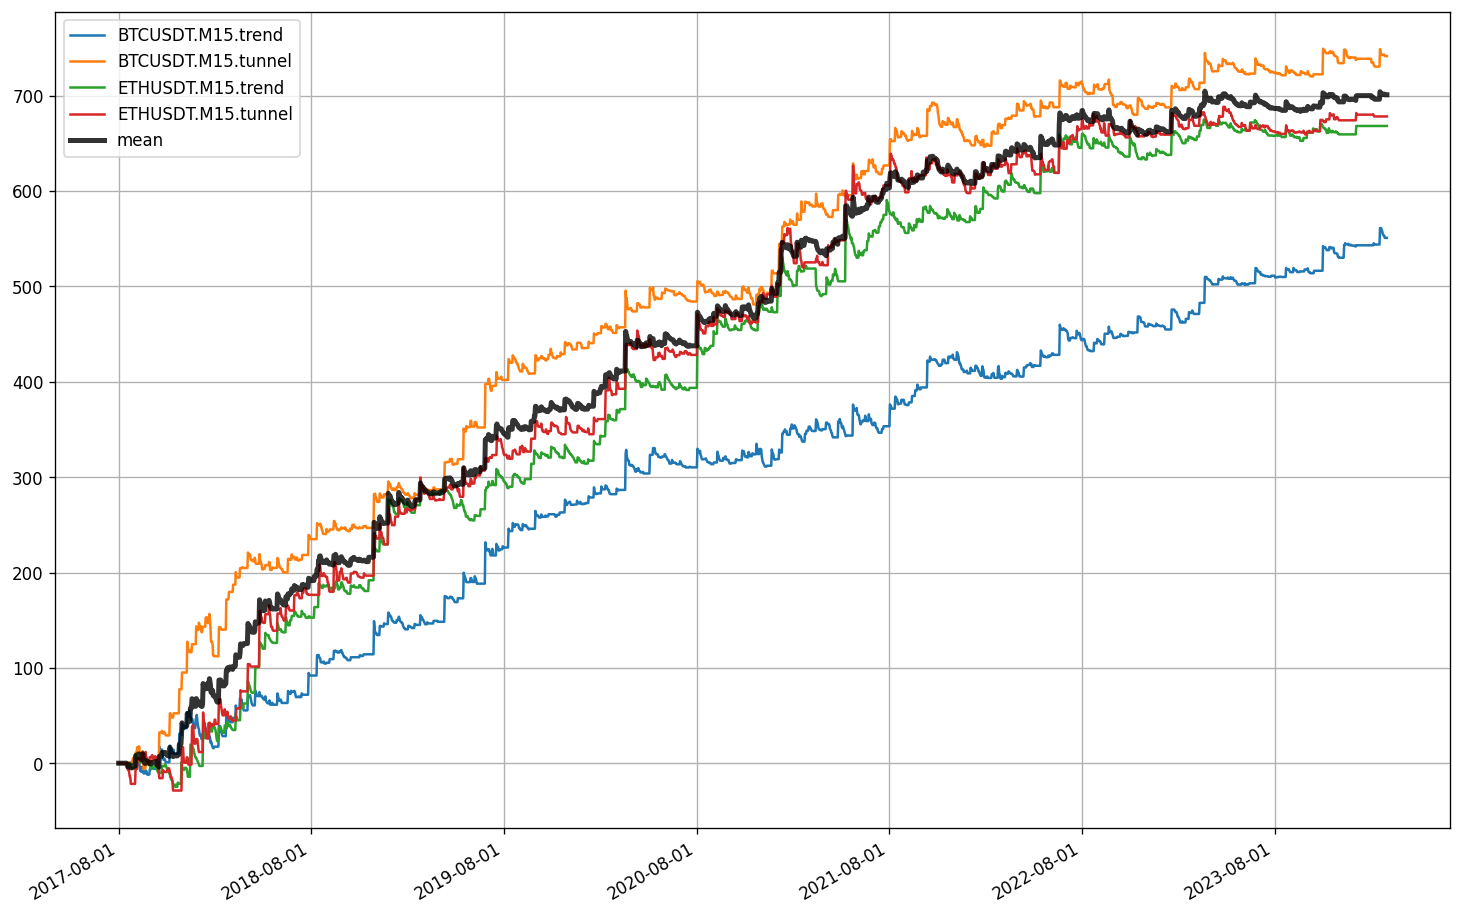

In [64]:
plt.figure(num=None, figsize=(15, 10), dpi=120)
legend = []
for k in sm.weights.keys():
    plt.plot(sm.profits.date, sm.profits[k], alpha=1)
    legend.append(k)
plt.plot(sm.profits.date, sm.profits["COMB"], "-", color="black", linewidth=3, alpha=0.8);
plt.grid("on")
plt.legend(legend+["mean"]);
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()